In [2]:
import os
import shutil

def organize_braTS_data(src_root="./data", dst_root="./dataset"):
    """
    Extract ./data to data and label form
    """
    os.makedirs(os.path.join(dst_root, "data"), exist_ok=True)
    os.makedirs(os.path.join(dst_root, "label"), exist_ok=True)
    case_number = 0
    for folder in sorted(os.listdir(src_root)):
        folder_path = os.path.join(src_root, folder)
        if os.path.isdir(folder_path):
            case_number += 1
            
            for file in os.listdir(folder_path):
                src_file = os.path.join(folder_path, file)
                if file.endswith("MRA.nii.gz"):
                    dst_file = os.path.join(dst_root, "data", f"data_{str(case_number)}.nii.gz")
                    shutil.move(src_file, dst_file)
                elif file.endswith("BinaryLabel.nii.gz"):
                    dst_file = os.path.join(dst_root, "label", f"label_{case_number}.nii.gz")
                    shutil.move(src_file, dst_file)

if __name__ == "__main__":
    organize_braTS_data()

In [3]:
import os
import nibabel as nib
import numpy as np
from scipy import ndimage
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

In [4]:
DEVICE = None
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Using CUDA!")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU!")
EPOCHS = 25
TRAIN_SPLIT = 0.8
LR = 1e-2
STEP_SIZE = 5
GAMMA = 0.1
MANUAL_SEED = 42
BATCH_SIZE = 2
CLASS = 5
TARGET_SIZE = 128

Using CUDA!


In [5]:
import torch
import numpy as np
import random

def set_random_seed(seed):
    """
    모든 관련 라이브러리의 랜덤 시드를 고정합니다.
    
    Args:
        seed (int): 고정할 랜덤 시드 값
    """
    # Python 내장 랜덤 시드 고정
    random.seed(seed)
    
    # NumPy 랜덤 시드 고정
    np.random.seed(seed)
    
    # PyTorch 랜덤 시드 고정
    torch.manual_seed(seed)  # CPU에서 PyTorch 랜덤 시드 고정
    torch.cuda.manual_seed(seed)  # GPU에서 PyTorch 랜덤 시드 고정 (CUDA 장치)
    torch.cuda.manual_seed_all(seed)  # 모든 GPU에서 PyTorch 랜덤 시드 고정
    
    # CuDNN 관련 설정
    torch.backends.cudnn.deterministic = True  # 결정적 알고리즘을 사용하여 결과 고정
    torch.backends.cudnn.benchmark = False  # 벤치마크 모드를 비활성화하여 성능 최적화 방지

# 시드 고정 예시
set_random_seed(MANUAL_SEED)

In [6]:
def read_nifti_file(filepath):
    """Read and load volume"""
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """Normalize the volume"""
    min_val = -1000
    max_val = 400
    volume[volume < min_val] = min_val
    volume[volume > max_val] = max_val
    volume = (volume - min_val) / (max_val - min_val)
    volume = volume.astype("float32")
    return volume

# interpolation?
def resize(image, target_size):
    """이미지 크기 조정 (PIL 없이 numpy 기반)"""
    print(image.ndim)
    # 이미지가 2D일 경우 (H, W)로 크기 조정
    if image.ndim == 2:
        return scipy.ndimage.zoom(image, (target_size[0] / image.shape[0], target_size[1] / image.shape[1]), order=1)
    # 이미지가 3D일 경우 (H, W, C)로 크기 조정
    elif image.ndim == 3:
        return np.concatenate([scipy.ndimage.zoom(image[..., i], (target_size[0] / image.shape[0], target_size[1] / image.shape[1]), order=1)[:, :, np.newaxis] for i in range(image.shape[2])], axis=-1)
    else:
        raise ValueError("Unsupported image dimensions")
            
def resize_volume(img):
    """Resize to 64x64x64"""
    desired_depth = TARGET_SIZE
    desired_width = TARGET_SIZE
    desired_height = TARGET_SIZE
    
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    depth_factor = desired_depth / current_depth
    width_factor = desired_width / current_width
    height_factor = desired_height / current_height
    
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [7]:
import os

# 경로 설정 (현재 작업 디렉토리 기준)
data_dir = './dataset/label'

# 숫자 001부터 369까지 파일이 있는지 확인 (_001, _002, ...)
expected_files = [f"label_{str(i)}.nii" for i in range(1, 25)]
print(expected_files)
# 실제 파일 목록 가져오기
try:
    actual_files = sorted(os.listdir(data_dir))
    # 실제 파일 목록에 있는지 확인
    missing_files = [file for file in expected_files if file not in actual_files]

    if missing_files:
        print("Missing files:", missing_files)
    else:
        print("All expected files are present.")
except FileNotFoundError:
    print(f"The directory {data_dir} does not exist.")


['label_1.nii', 'label_2.nii', 'label_3.nii', 'label_4.nii', 'label_5.nii', 'label_6.nii', 'label_7.nii', 'label_8.nii', 'label_9.nii', 'label_10.nii', 'label_11.nii', 'label_12.nii', 'label_13.nii', 'label_14.nii', 'label_15.nii', 'label_16.nii', 'label_17.nii', 'label_18.nii', 'label_19.nii', 'label_20.nii', 'label_21.nii', 'label_22.nii', 'label_23.nii', 'label_24.nii']
Missing files: ['label_1.nii', 'label_2.nii', 'label_3.nii', 'label_4.nii', 'label_5.nii', 'label_6.nii', 'label_7.nii', 'label_8.nii', 'label_9.nii', 'label_10.nii', 'label_11.nii', 'label_12.nii', 'label_13.nii', 'label_14.nii', 'label_15.nii', 'label_16.nii', 'label_17.nii', 'label_18.nii', 'label_19.nii', 'label_20.nii', 'label_21.nii', 'label_22.nii', 'label_23.nii', 'label_24.nii']


In [8]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

class MRADataset(Dataset):
    def __init__(self, data_dir, label_dir):
        self.data_paths = sorted([f for f in os.listdir(data_dir) if f.endswith('.nii.gz')])
        self.label_paths = sorted([f for f in os.listdir(label_dir) if f.endswith('.nii.gz')])
        self.data_dir = data_dir
        self.label_dir = label_dir
        
        # 데이터와 라벨의 개수가 일치하는지 확인
        assert len(self.data_paths) == len(self.label_paths), \
            f"Mismatch between data and label files: {len(self.data_paths)} | {len(self.label_paths)}"
    
    def __len__(self):
        return len(self.data_paths)
    
    def __getitem__(self, idx):
        data_path = os.path.join(self.data_dir, self.data_paths[idx])
        label_path = os.path.join(self.label_dir, self.label_paths[idx])
        
        data = read_nifti_file(data_path)
        label = read_nifti_file(label_path)

        data = normalize(data)
        data = resize_volume(data)
        label = resize_volume(label)

        # Convert numpy to torch tensor
        data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)     # Add channel dimension
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)   # For segmentation tasks, long type is needed for one-hot encoding
        label = torch.where(label != 0, torch.tensor(1, dtype=torch.float32, device=label.device), torch.tensor(0, dtype=torch.float32, device=label.device))

        return data, label


In [10]:
dataset = MRADataset("./dataset/data", "./dataset/label")
train_size = int(0.8 * len(dataset))
print(train_size)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

19


data shape:  torch.Size([1, 128, 128, 128]) <class 'torch.Tensor'>
label shape:  torch.Size([1, 128, 128, 128]) <class 'torch.Tensor'>
(128, 128, 128)
(128, 128, 128)


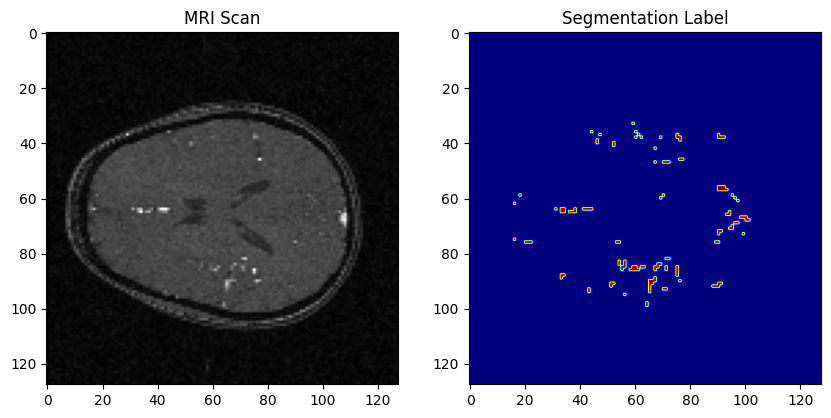

In [11]:
def visualize_sample(dataset, idx=0):
    """Visualize a single sample from the dataset"""
    data, label = dataset[idx]
    print("data shape: ", data.shape, type(data))
    print("label shape: ", label.shape, type(label))
    
    data = data.squeeze().numpy()
    label = label.squeeze().numpy()
    
    print(data.shape)
    print(label.shape)
    slice_idx = data.shape[-1] // 2  # Select middle slice
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data[:, :, slice_idx], cmap='gray')
    axes[0].set_title("MRI Scan")
    
    axes[1].imshow(label[:, :, slice_idx], cmap='jet')
    axes[1].set_title("Segmentation Label")
    
    plt.show()

visualize_sample(dataset, idx=0)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv3D -> BatchNorm -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, features=[32, 64, 128, 256, 512]):
        super(UNet3D, self).__init__()
        
        # stack contracting path
        self.encoder = nn.ModuleList()
        for feature in features:
            self.encoder.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        
        self.upconv = nn.ModuleList()
        self.decoder = nn.ModuleList()
        for feature in reversed(features):
            self.upconv.append(nn.ConvTranspose3d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(DoubleConv(feature * 2, feature))
        
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)
        # init weight
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
                nn.init.xavier_uniform_(m.weight)  # Xavier init for weights
                if m.bias is not None:
                    nn.init.zeros_(m.bias)  # Bias to zero
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.ones_(m.weight)  # Scale gamma to 1
                nn.init.zeros_(m.bias)  # Shift beta to 0

    def forward(self, x):
        # save skip connections
        skip_connections = []
        for enc in self.encoder:
            x = enc(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]
        for idx in range(len(self.upconv)):
            x = self.upconv[idx](x)
            x = torch.cat((x, skip_connections[idx]), dim=1)
            x = self.decoder[idx](x)
        
        return self.final_conv(x)

In [13]:
model = UNet3D(in_channels=1, out_channels=1)
x = torch.randn(1, 1, 64, 64, 64)  # Example 3D volume
output = model(x)
print(output.shape)

torch.Size([1, 1, 64, 64, 64])


Epoch 1/25: 100%|██████████| 8/8 [00:22<00:00,  2.77s/it, dice=7.22e-11, loss=0.0338]


Epoch 1/25
  Train Loss: 0.0508, Train Dice: 0.0301
  Val Loss: 0.0600, Val Dice: 0.0000
  Saved new best model with val loss: 0.0600


Epoch 2/25: 100%|██████████| 8/8 [00:21<00:00,  2.72s/it, dice=7.8e-11, loss=0.0278] 


Epoch 2/25
  Train Loss: 0.0324, Train Dice: 0.0000
  Val Loss: 0.0626, Val Dice: 0.0000
  No improvement for 1 epochs (best val loss: 0.0600 at epoch 1)


Epoch 3/25: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it, dice=8.28e-11, loss=0.0245]


Epoch 3/25
  Train Loss: 0.0296, Train Dice: 0.0000
  Val Loss: 0.3663, Val Dice: 0.0000
  No improvement for 2 epochs (best val loss: 0.0600 at epoch 1)


Epoch 4/25: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it, dice=0.000866, loss=0.0254]


Epoch 4/25
  Train Loss: 0.0279, Train Dice: 0.0001
  Val Loss: 0.2344, Val Dice: 0.0100
  No improvement for 3 epochs (best val loss: 0.0600 at epoch 1)


Epoch 5/25: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it, dice=0.0135, loss=0.0213] 


Epoch 5/25
  Train Loss: 0.0267, Train Dice: 0.0075
  Val Loss: 0.0412, Val Dice: 0.0000
  Saved new best model with val loss: 0.0412


Epoch 6/25: 100%|██████████| 8/8 [00:21<00:00,  2.72s/it, dice=0.0044, loss=0.0305] 


Epoch 6/25
  Train Loss: 0.0264, Train Dice: 0.0073
  Val Loss: 0.0285, Val Dice: 0.0091
  Saved new best model with val loss: 0.0285


Epoch 7/25: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it, dice=0.0116, loss=0.0326] 


Epoch 7/25
  Train Loss: 0.0263, Train Dice: 0.0104
  Val Loss: 0.0267, Val Dice: 0.0025
  Saved new best model with val loss: 0.0267


Epoch 8/25: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it, dice=0.0186, loss=0.0216] 


Epoch 8/25
  Train Loss: 0.0253, Train Dice: 0.0132
  Val Loss: 0.0258, Val Dice: 0.0118
  Saved new best model with val loss: 0.0258


Epoch 9/25: 100%|██████████| 8/8 [00:21<00:00,  2.74s/it, dice=0.0317, loss=0.0201] 


Epoch 9/25
  Train Loss: 0.0248, Train Dice: 0.0192
  Val Loss: 0.0249, Val Dice: 0.0214
  Saved new best model with val loss: 0.0249


Epoch 10/25: 100%|██████████| 8/8 [00:21<00:00,  2.74s/it, dice=0.0327, loss=0.0206]


Epoch 10/25
  Train Loss: 0.0245, Train Dice: 0.0239
  Val Loss: 0.0294, Val Dice: 0.0170
  No improvement for 1 epochs (best val loss: 0.0249 at epoch 9)


Epoch 11/25: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it, dice=0.0248, loss=0.0255]


Epoch 11/25
  Train Loss: 0.0244, Train Dice: 0.0312
  Val Loss: 0.0245, Val Dice: 0.0280
  Saved new best model with val loss: 0.0245


Epoch 12/25: 100%|██████████| 8/8 [00:21<00:00,  2.74s/it, dice=0.0376, loss=0.0269]


Epoch 12/25
  Train Loss: 0.0244, Train Dice: 0.0330
  Val Loss: 0.0240, Val Dice: 0.0355
  Saved new best model with val loss: 0.0240


Epoch 13/25: 100%|██████████| 8/8 [00:21<00:00,  2.74s/it, dice=0.0266, loss=0.0253]


Epoch 13/25
  Train Loss: 0.0243, Train Dice: 0.0346
  Val Loss: 0.0237, Val Dice: 0.0341
  Saved new best model with val loss: 0.0237


Epoch 14/25: 100%|██████████| 8/8 [00:21<00:00,  2.74s/it, dice=0.0387, loss=0.0202]


Epoch 14/25
  Train Loss: 0.0239, Train Dice: 0.0363
  Val Loss: 0.0244, Val Dice: 0.0332
  No improvement for 1 epochs (best val loss: 0.0237 at epoch 13)


Epoch 15/25: 100%|██████████| 8/8 [00:21<00:00,  2.74s/it, dice=0.0581, loss=0.0195]


Epoch 15/25
  Train Loss: 0.0237, Train Dice: 0.0392
  Val Loss: 0.0244, Val Dice: 0.0359
  No improvement for 2 epochs (best val loss: 0.0237 at epoch 13)


Epoch 16/25: 100%|██████████| 8/8 [00:21<00:00,  2.74s/it, dice=0.0585, loss=0.0195]


Epoch 16/25
  Train Loss: 0.0237, Train Dice: 0.0402
  Val Loss: 0.0235, Val Dice: 0.0370
  Saved new best model with val loss: 0.0235


Epoch 17/25: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it, dice=0.0326, loss=0.0288]


Epoch 17/25
  Train Loss: 0.0243, Train Dice: 0.0386
  Val Loss: 0.0233, Val Dice: 0.0371
  Saved new best model with val loss: 0.0233


Epoch 18/25: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it, dice=0.0399, loss=0.0244]


Epoch 18/25
  Train Loss: 0.0240, Train Dice: 0.0392
  Val Loss: 0.0232, Val Dice: 0.0370
  Saved new best model with val loss: 0.0232


Epoch 19/25: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it, dice=0.0372, loss=0.0213]


Epoch 19/25
  Train Loss: 0.0238, Train Dice: 0.0391
  Val Loss: 0.0231, Val Dice: 0.0373
  Saved new best model with val loss: 0.0231


Epoch 20/25: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it, dice=0.0486, loss=0.0235]


Epoch 20/25
  Train Loss: 0.0240, Train Dice: 0.0400
  Val Loss: 0.0232, Val Dice: 0.0375
  No improvement for 1 epochs (best val loss: 0.0231 at epoch 19)


Epoch 21/25: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it, dice=0.0284, loss=0.0249]


Epoch 21/25
  Train Loss: 0.0240, Train Dice: 0.0391
  Val Loss: 0.0232, Val Dice: 0.0368
  No improvement for 2 epochs (best val loss: 0.0231 at epoch 19)


Epoch 22/25: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it, dice=0.0405, loss=0.0235]


Epoch 22/25
  Train Loss: 0.0239, Train Dice: 0.0394
  Val Loss: 0.0232, Val Dice: 0.0371
  No improvement for 3 epochs (best val loss: 0.0231 at epoch 19)


Epoch 23/25: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it, dice=0.0402, loss=0.0244]


Epoch 23/25
  Train Loss: 0.0240, Train Dice: 0.0390
  Val Loss: 0.0232, Val Dice: 0.0371
  No improvement for 4 epochs (best val loss: 0.0231 at epoch 19)


Epoch 24/25: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it, dice=0.0308, loss=0.0218]


Epoch 24/25
  Train Loss: 0.0238, Train Dice: 0.0381
  Val Loss: 0.0231, Val Dice: 0.0373
  No improvement for 5 epochs (best val loss: 0.0231 at epoch 19)
Early stopping triggered after 24 epochs
Training complete. Best model saved at epoch 19 with validation loss 0.0231


/tmp/ipykernel_2112601/1548581364.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/3DUNet_best.pth'))


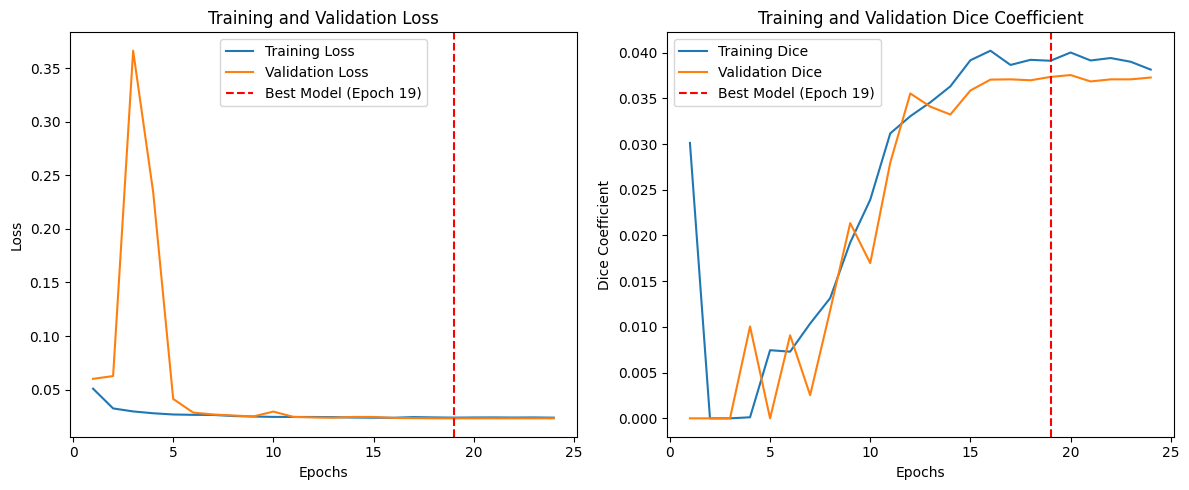

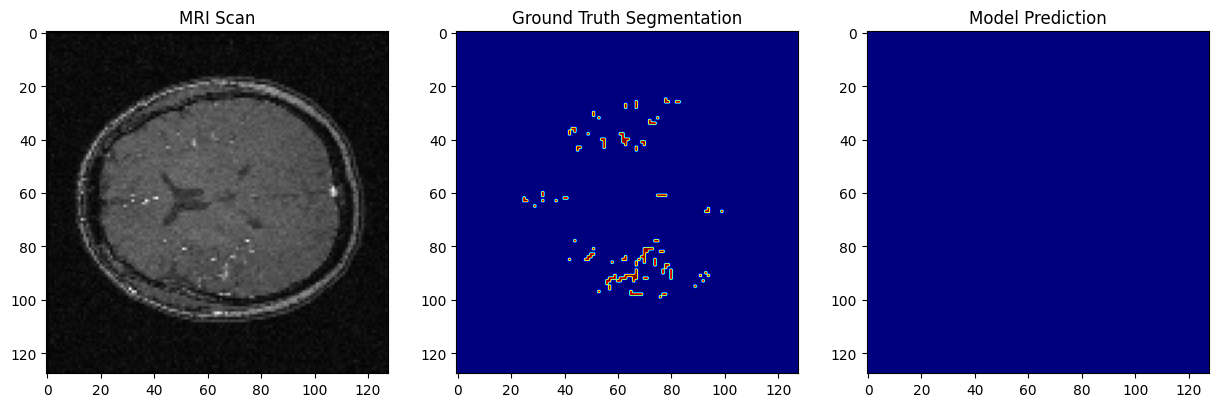

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Set up parameters for early stopping and model saving
patience = 5  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
counter = 0  # Counter for early stopping
best_epoch = 0

# Split training data into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

# Dice coefficient for accuracy calculation
def dice_coefficient(y_pred, y_true, smooth=1e-6):
    y_pred = torch.sigmoid(y_pred) > 0.5
    y_pred = y_pred.float()
    intersection = (y_pred * y_true).sum()
    return (2. * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)

# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_dice = []
val_dice = []

model.to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    epoch_loss = 0
    epoch_dice = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for data, label in progress_bar:
        data, label = data.to(DEVICE), label.to(DEVICE)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        epoch_loss += loss.item()
        dice = dice_coefficient(output, label)
        epoch_dice += dice.item()
        
        progress_bar.set_postfix(loss=loss.item(), dice=dice.item())
    
    # Calculate average training metrics
    avg_train_loss = epoch_loss / len(train_loader)
    avg_train_dice = epoch_dice / len(train_loader)
    train_losses.append(avg_train_loss)
    train_dice.append(avg_train_dice)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_dice_score = 0
    
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)
            
            output = model(data)
            loss = criterion(output, label)
            
            # Calculate metrics
            val_loss += loss.item()
            dice = dice_coefficient(output, label)
            val_dice_score += dice.item()
    
    # Calculate average validation metrics
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice_score / len(val_loader)
    val_losses.append(avg_val_loss)
    val_dice.append(avg_val_dice)
    
    # Print epoch stats
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Dice: {avg_val_dice:.4f}")
    
    # Check if this is the best model so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), './model/3DUNet_best.pth')
        print(f"  Saved new best model with val loss: {best_val_loss:.4f}")
    else:
        counter += 1
        print(f"  No improvement for {counter} epochs (best val loss: {best_val_loss:.4f} at epoch {best_epoch})")
    
    # Early stopping
    if counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break
    
    # Learning rate scheduler step
    scheduler.step()

print(f"Training complete. Best model saved at epoch {best_epoch} with validation loss {best_val_loss:.4f}")

# Load the best model for evaluation or further use
model.load_state_dict(torch.load('./model/3DUNet_best.pth'))

# Plot training and validation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (Epoch {best_epoch})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_dice) + 1), train_dice, label='Training Dice')
plt.plot(range(1, len(val_dice) + 1), val_dice, label='Validation Dice')
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (Epoch {best_epoch})')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.title('Training and Validation Dice Coefficient')

plt.tight_layout()
plt.savefig('./training_metrics.png')
plt.show()

# Visualize a sample prediction using the best model
def visualize_prediction(model, dataset, idx=0):
    model.eval()
    data, label = dataset[idx]
    data = data.unsqueeze(0).to(DEVICE)  # Add batch dimension
    
    with torch.no_grad():
        output = model(data)
        prediction = torch.sigmoid(output) > 0.5
    
    # Move tensors to CPU and convert to numpy
    data = data.squeeze().cpu().numpy()
    label = label.squeeze().cpu().numpy()
    prediction = prediction.squeeze().cpu().numpy()
    
    slice_idx = data.shape[-1] // 2  # Select middle slice
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(data[:, :, slice_idx], cmap='gray')
    axes[0].set_title("MRI Scan")
    
    axes[1].imshow(label[:, :, slice_idx], cmap='jet')
    axes[1].set_title("Ground Truth Segmentation")
    
    axes[2].imshow(prediction[:, :, slice_idx], cmap='jet')
    axes[2].set_title("Model Prediction")
    
    plt.savefig('./sample_prediction.png')
    plt.show()

# Visualize a prediction from the validation set
val_idx = np.random.randint(0, len(val_subset))
visualize_prediction(model, val_subset, val_idx)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import nibabel as nib
from tqdm import tqdm

def save_as_nifti(tensor, filename):
    """ Save a tensor as a NIfTI file. """
    nifti_img = nib.Nifti1Image(tensor, affine=np.eye(4))  # 단위 행렬 사용
    nib.save(nifti_img, filename)

def multiclass_dice_coeff(input, target, epsilon=1e-6):
    """
    Compute Dice Score for multi-class segmentation.
    
    Args:
        input (torch.Tensor): Model output logits (D, H, W).
        target (torch.Tensor): Ground truth labels (D, H, W).
        epsilon (float): Small value to avoid division by zero.
        
    Returns:
        mean_dice (float): Mean Dice Score across all classes.
    """
    print(input.shape)
    print(target.shape)
    intersection = (input * target).sum()
    union = input.sum() + target.sum()
    
    dice_per_class = (2. * intersection + epsilon) / (union + epsilon)
    mean_dice = dice_per_class.mean()  # 전체 클래스 평균 Dice Score

    return mean_dice

# ============== Test Loop ==============
save = False
batch_dice_scores = []

model.to(DEVICE)
model.eval()
total_loss = 0
criterion = nn.BCEWithLogitsLoss()

with torch.no_grad():
    for batch_idx, (data, label) in tqdm(enumerate(test_loader), desc="Testing"):
        data, label = data.to(DEVICE), label.to(DEVICE)

        # 모델 예측
        output = model(data)  # Output: (batch, C, D, H, W)
        unique_values = torch.unique(output)
        
        print("Tensor의 유일한 값:", unique_values)
        # 손실 계산
        loss = criterion(output, label)
        output = torch.sigmoid(output)  # 시그모이드 적용
        output = (output >= 0.5).float()  # Threshold 적용 (0.5 이상이면 1, 아니면 0)

        total_loss += loss.item()

        # Dice Score 계산
        batch_dice = []
        for i in range(data.size(0)):  # 배치 내 개별 샘플 처리
            input = output[i].squeeze().cpu().numpy()
            target = label[i].squeeze().cpu().numpy()
            dice = multiclass_dice_coeff(input, target)  
            batch_dice.append(dice.item())

        batch_dice_scores.extend(batch_dice)  # 전체 결과 리스트에 추가

        # 저장 (1회만 실행)
        if not save:
            pred = output[0].squeeze().cpu().numpy()
            gt_label = label[0].squeeze().cpu().numpy()

            save_as_nifti(pred.astype(np.int16), f"pred_{batch_idx}.nii")
            save_as_nifti(gt_label.astype(np.int16), f"label_{batch_idx}.nii")
            save = True

# 최종 평균 Dice Score 및 Loss 계산
avg_dice = np.mean(batch_dice_scores)
avg_loss = total_loss / len(test_loader)

print(f"Test Dice Accuracy: {avg_dice:.4f}")
print(f"Average Test Loss: {avg_loss:.4f}")

Testing: 1it [00:02,  2.17s/it]

Tensor의 유일한 값: tensor([-15.4174, -15.4135, -15.4087,  ...,   0.2026,   0.2041,   0.2082],
       device='cuda:0')
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)


Testing: 2it [00:04,  2.16s/it]

Tensor의 유일한 값: tensor([-15.4229, -15.4216, -15.4183,  ...,   0.2376,   0.2552,   0.2568],
       device='cuda:0')
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)


Testing: 3it [00:05,  1.80s/it]

Tensor의 유일한 값: tensor([-15.4878, -15.4456, -15.4434,  ...,   0.2339,   0.2366,   0.2370],
       device='cuda:0')
(128, 128, 128)
(128, 128, 128)
Test Dice Accuracy: 0.0306
Average Test Loss: 0.0231
